# Hello World Tutorial from IBM Qiskit

In a quantum program, quantum circuits are the native format in which to represent quantum instructions, and operators represent the observables to be measured.

# Step 1. Map the problem to a quantum-native format 

The following code cell creates a circuit that produces a Bell state, which is a specific two-qubit entangled state.

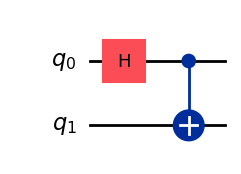

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
 
# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

The following code cell uses the quantum_info package to create the two-qubit Pauli operator Z on qubit 0 and Z on qubit 1. If the state is entangled, then the correlation between qubit 0 and qubit 1 is one.

In [24]:
# Set up six different observables.
observables_labels = ["ZZ", "ZI", "IZ", "XX", "XI"]
observables = [SparsePauliOp(label) for label in observables_labels]

## Step 2. Optimize the circuits and operators

Even though the circuit and operators for this example are quite simple, we still need to convert its instructions into those of a backend device's Instruction Set Architecture (ISA). This ensures the circuit complies with the constraints of a device (namely its native basis gates and qubit connectivity).

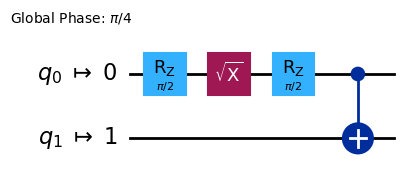

In [12]:
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService(channel="ibm_quantum", token="340f0988ee08967d19be380d6bd213d8d4ff3ee0fe657cd3154f70abc42c1568fdd485cc84a0caa0a658e61d03c13f5f1e6838f6ea9bf2aa2b87cf8cd840b676")
 
# Use the following code instead if you want to run on a simulator:
from qiskit_ibm_runtime.fake_provider import FakeCairoV2
backend = FakeCairoV2()
 
# Run on the least-busy backend you have access to
# backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw('mpl', idle_wires=False)

## Step 3. Execute using a quantum primitive function

Quantum computers can produce random results, so you'll often want to collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable using the Estimator class. Estimator is one of our two primitives; the other is Sampler, which can be used to get data from a quantum computer. These objects possess a run() method that executes the selection of circuits, observables, and parameters (if applicable), using what's known as a primitive unified bloc (PUB).

In [25]:
# Construct the Estimator instance we want to use.
 
estimator = Estimator(backend)
estimator.options.resilience_level = 1
# estimator.options.default_shots = 5000
 
observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, observables)])
 
# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

pub_result.data.ensemble_standard_error

AttributeError: 'DataBin' object has no attribute 'ensemble_standard_error'

<ErrorbarContainer object of 3 artists>

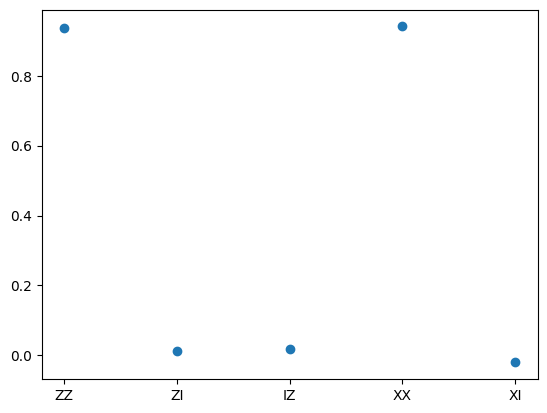

In [26]:
# Plot the result
 
from matplotlib import pyplot as plt
 
data = observables_labels
values = pub_result.data.evs
 
# errors = pub_result.data.ensemble_standard_error
 
# plt.errorbar(observables_labels, values, yerr=errors, fmt="o")
plt.errorbar(observables_labels, values, fmt="o")